<a href="https://colab.research.google.com/github/Nikhil-Khetani/House-Image-Price-Prediction/blob/main/colab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
#!ls /mydrive
!unzip /mydrive/House-Image-Price-Prediction/Cleaned_pics.zip -d data



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ln: failed to create symbolic link '/mydrive/My Drive': File exists
Archive:  /mydrive/House-Image-Price-Prediction/Cleaned_pics.zip
replace data/socal2 - Copy/socal_pics/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [17]:
IMAGE_PATH = '/content/data/socal2 - Copy/socal_pics'
# IMAGE_PATH = 'data/socal2/socal_pics/'
CSV_PATH = '/content/gdrive/MyDrive/House-Image-Price-Prediction/socal_fixed.csv'
# CSV_PATH = 'socal_fixed.csv'

In [18]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

plt.ion()   # interactive mode

In [19]:
data_csv = pd.read_csv(CSV_PATH)
data_csv.drop(columns='Unnamed: 0', inplace=True)
print(data_csv.count())
data_csv.head() 

image_id    12518
street      12518
citi        12518
n_citi      12518
bed         12518
bath        12518
sqft        12518
price       12518
dtype: int64


,image_id,street,citi,n_citi,bed,bath,sqft,price
0,1,124 C Street W,"Brawley, CA",48,3,2.0,713,228500
1,4,2207 R Carrillo Court,"Calexico, CA",55,4,3.0,2547,385100
2,6,1100 CAMILIA Street,"Calexico, CA",55,4,3.0,2769,415000
3,7,803 Chaparral Court,"Brawley, CA",48,5,2.1,2600,545000
4,8,803 Chaparral Court,"Brawley, CA",48,5,2.1,2600,545000


In [20]:
for i in data_csv.columns:
    print(data_csv[i].value_counts())

4094     1
9470     1
13596    1
3355     1
1306     1
        ..
8785     1
10832    1
4687     1
6734     1
2049     1
Name: image_id, Length: 12518, dtype: int64
Address not provided      18
1930 W San Marcos Blvd     5
315 Verbena Drive          5
65565 Acoma Avenue         5
40171 Wilson Street        4
                          ..
17001 Sandoval Lane        1
13944 Powers Rd            1
536 Golden West Drive      1
1374 Lazy Lane             1
2600 La Paz Avenue         1
Name: street, Length: 10126, dtype: int64
San Diego, CA           475
Los Angeles, CA         311
Lancaster, CA           296
Riverside, CA           253
Corona, CA              228
                       ... 
El Mirage, CA             1
Salton City, CA           1
Hawaiian Gardens, CA      1
Cedarpines Park, CA       1
Lakeview Terrace, CA      1
Name: citi, Length: 403, dtype: int64
320    475
207    311
193    296
310    253
87     228
      ... 
232      1
317      1
382      1
374      1
108      1
Name: n

In [21]:
class HouseDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_csv = dataframe
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.data_csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir, str(self.data_csv.iloc[idx, 0])+'.jpg')
        img = Image.open(img_name).convert("RGB")
        # image = io.imread(img_name)
        price = torch.tensor(float(self.data_csv.iloc[idx, 7]))
        if self.transform:
            image = self.transform(img)
        return image, price

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, price = sample['image'], sample['price']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        #landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'price': price}

class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, price = sample['image'], sample['price']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        #price = price - [left, top]

        return {'image': image, 'price': price}




class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, price = sample['image'], sample['price']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'price': torch.from_numpy(price)}

In [22]:
train_transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

test_transform = transforms.Compose(
        [
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )





In [23]:
from sklearn.model_selection import train_test_split

data = pd.read_csv(CSV_PATH)
data.drop(columns='Unnamed: 0', inplace=True)


train_data, test_data = train_test_split(data, test_size = 0.3)

train_dataset = HouseDataset(dataframe=data,
                             root_dir=IMAGE_PATH,
                             transform=train_transform)

test_dataset = HouseDataset(dataframe=test_data, 
                            root_dir=IMAGE_PATH,
                            transform=test_transform)

In [24]:
import torch.nn as nn
import torchvision.models as models

class CNN(nn.Module):
    def __init__(self, train_CNN=False, num_classes=1):
        super(CNN, self).__init__()
        self.train_CNN = train_CNN
        self.inception = models.inception_v3(pretrained=True, aux_logits=False)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.relu_out = nn.ReLU()

    def forward(self, images):
        features = self.inception(images)
        return self.relu_out(self.dropout(self.relu(features))).squeeze(1)

In [25]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
num_epochs = 100
learning_rate = 0.00001
train_CNN = False
batch_size = 32
shuffle = True
# pin_memory = True
num_workers = 1

In [27]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                        shuffle=shuffle, num_workers=num_workers)
test_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=num_workers)

0 torch.Size([32, 3, 299, 299]) torch.Size([32])
1 torch.Size([32, 3, 299, 299]) torch.Size([32])
2 torch.Size([32, 3, 299, 299]) torch.Size([32])
3 torch.Size([32, 3, 299, 299]) torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 torch.Size([32, 3, 299, 299]) torch.Size([32])


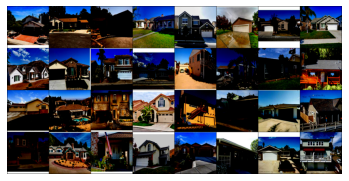

In [28]:
def show_images_batch(sample_batched):
    images_batch, prices_batch = sample_batched
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))


for i_batch, sample_batched in enumerate(train_dataloader):
    print(i_batch, sample_batched[0].size(),
          sample_batched[1].size())
    if i_batch == 4:
        show_images_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [29]:
from tqdm import tqdm
model = CNN().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for name, param in model.inception.named_parameters():
    if "fc.weight" in name or "fc.bias" in name:
        param.requires_grad = True
    else:
        param.requires_grad = train_CNN

In [30]:
def check_accuracy(loader, model):
    if loader == train_dataloader:
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on validation data")

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            predictions = torch.tensor([1.0 if i >= 0.5 else 0.0 for i in scores]).to(device)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
    
    print(f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}")
    model.train()
    return f"{float(num_correct)/float(num_samples)*100:.2f}"

In [32]:
def train():
    model.train()
    for epoch in range(num_epochs):
        loop = tqdm(train_dataloader, total = len(train_dataloader), leave = True)
        if epoch % 2 == 0:
            # loop.set_postfix(val_acc = check_accuracy(test_dataloader, model))
            pass
        for imgs, labels in loop:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
            loop.set_postfix(loss = loss.item())

In [33]:
train()

Epoch [99/100]: 100%|██████████| 392/392 [01:34<00:00,  4.15it/s, loss=3.66e+11]
